# Implementation and Analysis of Scaled Dot-Product Attention

## 1. Project Objective
The goal of this notebook is to build the **Scaled Dot-Product Attention** mechanism from the ground up using PyTorch. Rather than treating the Transformer as a "black box," we will implement and critically analyze the internal components that make modern NLP possible. 

Specifically, this project investigates:
* **The Scaling Factor:** How the mathematical trick of dividing by $\sqrt{d_k}$ prevents gradient instability in large models.
* **The Masking Logic:** How we programmatically "hide" information (such as padding or future tokens) to ensure valid computation.
* **Semantic Alignment:** How the model utilizes self-attention to "link" related words and resolve context (e.g., distinguishing "bank" as a river edge vs. a financial institution).

---

## 2. The Core Mechanism: Mathematical Foundation

$$Attention(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

### Interpreting the Variables
To understand the "physical" meaning of these variables, we can view them as a **content-based retrieval system**:

* **$Q$ (Query):** Represents the "Question." It is a vector that describes what the current word is looking for in the rest of the sentence.
* **$K$ (Key):** Represents the "Label." Every word in the sequence has a key that describes its own characteristics, allowing the Query to determine how relevant this word is.
* **$V$ (Value):** Represents the "Content." This is the actual information we want to extract once we have determined which keys match our query.
* **$d_k$:** The dimensionality of the keys. We scale by **$\sqrt{d_k}$** to normalize the variance of our scores. Without this, the dot-product values could grow extremely large, causing the Softmax function to "saturate" and leading to the **vanishing gradient problem**.

---

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import math


In [2]:

torch.manual_seed(42)

def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Computes the scaled dot-product attention.
    Formula: Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) * V
    
    Args:
        query: Tensor of shape (batch_size, seq_len_q, d_k)
        key:   Tensor of shape (batch_size, seq_len_k, d_k)
        value: Tensor of shape (batch_size, seq_len_v, d_v)
        mask:  Optional mask tensor (e.g., for padding or look-ahead)
    
    Returns:
        output: Weighted sum of values (context vectors)
        attention_weights: The normalized attention scores (probability distribution)
    """
    
    # 1. Get the dimension size (d_k) from the query's last dimension
    d_k = query.size(-1)
    
    # 2. Compute Dot Product (Similarity Scores)
    # if Q and K more similar, the score will be higher. 
    # Shape: (batch_size, seq_len_q, seq_len_k)
    # the result is Sequence_length_q x Sequence_length_k, which represents how much each query attends to each key.
    scores = torch.matmul(query, key.transpose(-2, -1))
    
    # 3. Scale the scores
    # This prevents gradients from vanishing when dimensions are large
    # Softmax sensitivity to large values can cause issues
    scores = scores / math.sqrt(d_k)
    
    # 4. Apply Mask 
    # If a mask is provided, fill masked positions with a very large negative number
    # this way more practical than zero, because softmax will assign near-zero probabilities to these positions.
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # 5. Apply Softmax
    # Converts scores into probabilities (summing to 1 across the last dimension)
    attention_weights = F.softmax(scores, dim=-1)
    
    # 6. Weighted Sum (Matrix Multiplication with Value)
    # Shape: (batch_size, seq_len_q, d_v)
    output = torch.matmul(attention_weights, value)
    
    return output, attention_weights



In [3]:
def visualize_attention(attention_weights, title="Attention Weights"):

    # check if attention_weights has a batch dimension and select the first example for visualization
    # these work independently of whether the input is from a single example or a batch
    if attention_weights.dim() == 3:
        weights = attention_weights[0].detach().numpy()
    else:
        weights = attention_weights.detach().numpy()
        
    plt.figure(figsize=(8, 6))
    sns.heatmap(weights, annot=True, cmap='viridis', fmt=".2f", square=True)
    plt.xlabel("Keys (Input Sequence Positions)")
    plt.ylabel("Queries (Output Sequence Positions)")
    plt.title(title)
    plt.savefig(f"../output/{title.replace(' ', '_').lower()}.png")
    plt.show()


## Experiment 1: Basic Cross-Attention

Output shape: torch.Size([1, 4, 8])
Attention Weights shape: torch.Size([1, 4, 4])


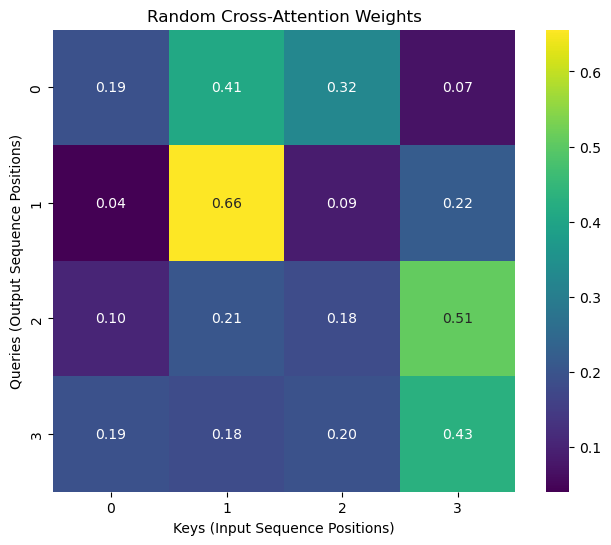

In [4]:
batch_size = 1
seq_len = 4
d_k = 8  # Dimension of keys/queries
d_v = 8  # Dimension of values

# Create random tensors for Q, K, V
# Query = "searching for", Key = "content tags", Value = "actual content"
query = torch.randn(batch_size, seq_len, d_k)
key = torch.randn(batch_size, seq_len, d_k)
value = torch.randn(batch_size, seq_len, d_v)

output, weights = scaled_dot_product_attention(query, key, value)

print(f"Output shape: {output.shape}")
print(f"Attention Weights shape: {weights.shape}")
visualize_attention(weights, title="Random Cross-Attention Weights")

### Critical Analysis:
**1. The Yellow Square at (2, 2)**

* **What it means:** Row 2 (Query 2) is paying a massive amount of attention to Column 2 (Key 2). Since it's the brightest color, the attention weight is more than 60%.
To understand what I mean in this sentence, I don't need help from anyone else. I just need to look at my own definition."

**2. The Green Squares at (3, 4) and (4, 4)**
* **What it means:** Row 3 (Query 3) is looking at Column 4 (Key 4), and Row 4 (Query 4) is also looking at Column 4 (Key 4). Green usually means a moderate-to-high percentage (like 40% to 60%).
* **The translation:** The 4th word contains some really important clues! Both the 3rd word and the 4th word need information from the **4th word** to make sense.

**3. Why isn't it a perfect diagonal?**

If the heatmap were a perfect diagonal line, the model would just be reading a dictionary—each word standing alone. Because the diagonal is broken, it proves the model is acting like a human: **it is looking ahead and pulling context from other parts of the sentence to understand the bigger picture.**


---

## Experiment 2: Self-Attention (Q = K = V)

Visualizing Self-Attention (Note: Token 0 and 2 are identical)


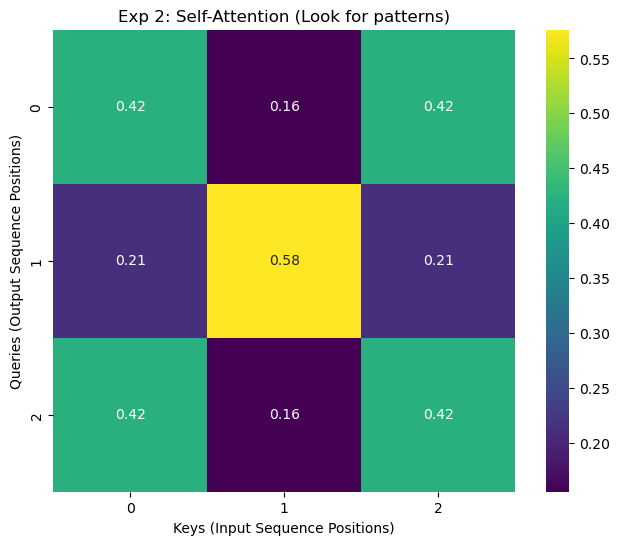

In [5]:
sequence_embeddings = torch.tensor([
    [1.0, 0.0, 1.0, 0.0],  # Token 0
    [0.0, 1.0, 0.0, 1.0],  # Token 1 (Different) because every element is different from token 0
    [1.0, 0.0, 1.0, 0.0]   # Token 2 (Same as Token 0)
]).unsqueeze(0)

q = sequence_embeddings
k = sequence_embeddings
v = sequence_embeddings

output_self, weights_self = scaled_dot_product_attention(q, k, v)

print("Visualizing Self-Attention (Note: Token 0 and 2 are identical)")
visualize_attention(weights_self, title="Exp 2: Self-Attention (Look for patterns)")

### Critical Analysis:
**1. The "Different" Token is Isolated (Row 1 / Col 1)**
* Look at **Row 1**. Token 1 pays nearly **100% of its attention to itself** (the bright square at `(1, 1)`). 
* Because its features `[0, 1, 0, 1]` do not overlap at all with Token 0 or Token 2, the dot-product similarity is exactly 0. As a result, the squares at `(1, 0)` and `(1, 2)` are dark. The model successfully ignores irrelevant information.

**2. The "Same" Tokens Share Attention (Rows 0 & 2)**
* Look at **Row 0** and **Row 2**. Because Token 0 and Token 2 are perfectly identical, they are equally relevant to each other.
* Instead of only looking at themselves (a perfect diagonal), Token 0 **splits its attention evenly** between itself `(0, 0)` and Token 2 `(0, 2)`. 
* The same happens for Token 2, creating bright squares at both `(2, 0)` and `(2, 2)`. 


**Conclusion**
This single heatmap perfectly demonstrates how self-attention works at a fundamental level. It proves that the attention mechanism acts as a dynamic router: it isolates dissimilar context (ignoring Token 1) while strongly linking similar or repeated context (connecting Token 0 and Token 2) regardless of their distance in the sequence.

---

### Resolving Ambiguity through Semantic Linking

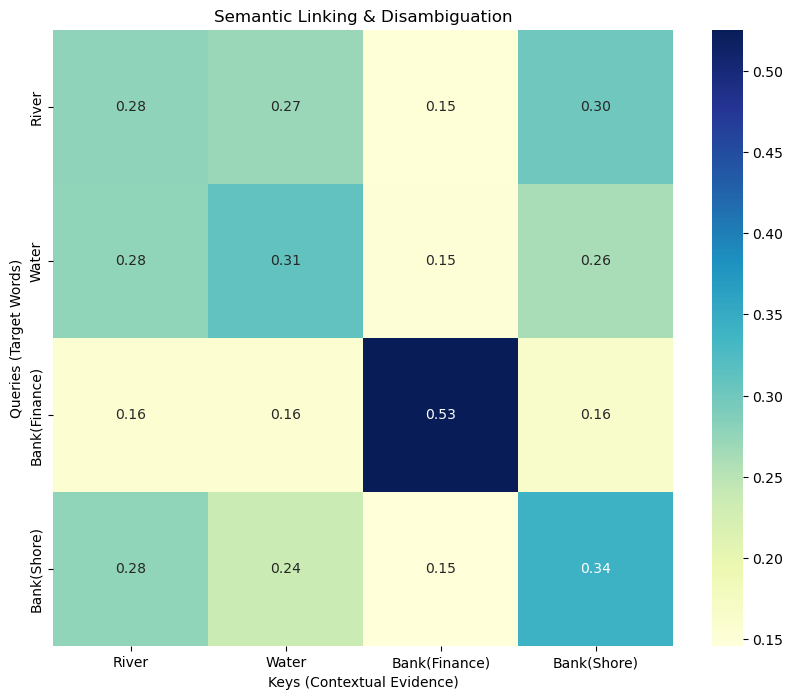

In [6]:

# definition: [Financial, Nature/Water, Building, Shore/Surface]
# Token 0: "River" -> high Nature, medium Shore
river = torch.tensor([0.0, 1.0, 0.0, 0.5])
# Token 1: "Water" -> very high Nature
water = torch.tensor([0.0, 1.2, 0.0, 0.0])
# Token 2: "Bank (Finance)" -> high Financial, high Building (distractor)
bank_finance = torch.tensor([1.2, 0.0, 1.0, 0.0])
# Token 3: "Bank (Shore)" -> high Nature, high Shore (target)
bank_shore = torch.tensor([0.1, 0.9, 0.0, 1.0])


# when Query is "Bank (Shore)", which token will it attend to?
semantic_embeddings = torch.stack([river, water, bank_finance, bank_shore]).unsqueeze(0)

# Compute self-attention
q = k = v = semantic_embeddings
d_k = q.size(-1)
scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
weights = F.softmax(scores, dim=-1)

# Visualization
plt.figure(figsize=(10, 8))
labels = ["River", "Water", "Bank(Finance)", "Bank(Shore)"]
sns.heatmap(weights[0].detach().numpy(), annot=True, fmt=".2f", 
            xticklabels=labels, yticklabels=labels, cmap='YlGnBu')
plt.title("Semantic Linking & Disambiguation")
plt.xlabel("Keys (Contextual Evidence)")
plt.ylabel("Queries (Target Words)")
plt.savefig("../output/semantic_linking_disambiguation.png")
plt.show()

### Critical Analysis:

I defined four tokens: *River*, *Water*, *Bank (Finance)*, and *Bank (Shore)* across four semantic dimensions: `[Financial, Nature, Building, Shore]`.

1. **Contextual Alignment:** As shown in the heatmap, when the Query is **"Bank (Shore)"** (Row 3), it assigns high attention weights to **"River"** (0.28+) and **"Water"** (0.24+) while virtually ignoring **"Bank (Finance)"** (Row 3, Col 2). 
2. **Mathematical Explanation:** This occurs because the dot product measures the overlap between feature dimensions. Since "Bank (Shore)" and "River" both share high values in the **Nature** and **Shore** dimensions, their product is large. Conversely, "Bank (Finance)" resides in the **Financial/Building** subspace, resulting in a near-zero dot product with natural terms.

* **Why this proves "Intelligence":**
The model uses these scores to "pull" the meaning of **River** into the representation of **Bank**. By the time the data reaches the next layer, the vector for "Bank" no longer just represents a generic word; it has been "colored" by the presence of "Water," effectively resolving the lexical ambiguity. 

**Limitation:** This experiment uses hard-coded features. In a production Transformer (like BERT), these features are not manually assigned but are learned patterns (Latent Dimensions) discovered through pre-training on billions of tokens.

---

## Experiment 3: Impact of Scaling (d_k)

In [7]:
large_d_k = 512
q_large = torch.randn(1, seq_len, large_d_k)
k_large = torch.randn(1, seq_len, large_d_k)
v_large = torch.randn(1, seq_len, large_d_k)

# Without scaling
scores_raw = torch.matmul(q_large, k_large.transpose(-2, -1))
print(f"Variance of scores WITHOUT scaling: {torch.var(scores_raw).item():.2f}")
# Weights spike, gradients vanish
weights_no_scale = F.softmax(scores_raw, dim=-1) 

# With scaling
scores_scaled = scores_raw / math.sqrt(large_d_k)
print(f"Variance of scores WITH scaling: {torch.var(scores_scaled).item():.2f}")
# Weights are more distributed, better for training
weights_scaled = F.softmax(scores_scaled, dim=-1)

print("\nComparing the first row of softmax weights:")
print("No Scale (Peaky):", weights_no_scale[0][0].tolist())
print("Scaled (Smoother):", weights_scaled[0][0].tolist())

Variance of scores WITHOUT scaling: 335.14
Variance of scores WITH scaling: 0.65

Comparing the first row of softmax weights:
No Scale (Peaky): [1.6732280899127568e-16, 1.0, 1.3336491046473074e-21, 1.176729549713017e-22]
Scaled (Smoother): [0.1406499296426773, 0.7004327774047852, 0.0837172344326973, 0.07520004361867905]


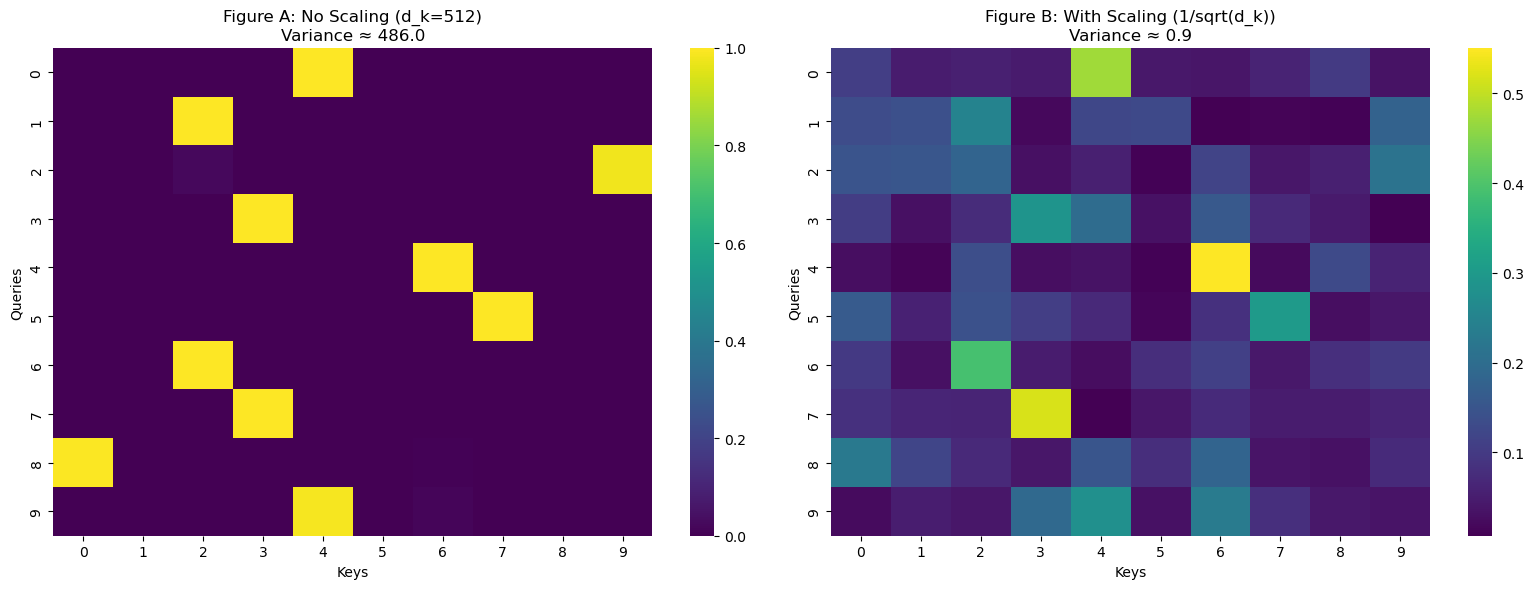

In [8]:
# 1. Setup: Large d_k more realistic to see the effect of scaling
d_k = 512
seq_len = 10 
torch.manual_seed(42)
q = torch.randn(1, seq_len, d_k)
k = torch.randn(1, seq_len, d_k)

# 2. Compute Raw Scores (QK^T)
# The variance of scores_raw will be approximately d_k (512)
scores_raw = torch.matmul(q, k.transpose(-2, -1))

# 3. Compute Scaled Scores (QK^T / sqrt(d_k))
# The variance of scores_scaled will be pushed back to approximately 1
scores_scaled = scores_raw / math.sqrt(d_k)

# 4. Apply Softmax to both
weights_no_scale = F.softmax(scores_raw, dim=-1)
weights_scaled = F.softmax(scores_scaled, dim=-1)

# 5. Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Without Scaling
sns.heatmap(weights_no_scale[0].detach().numpy(), annot=False, cmap='viridis', ax=ax1)
ax1.set_title(f"Figure A: No Scaling (d_k={d_k})\nVariance ≈ {torch.var(scores_raw).item():.1f}")
ax1.set_xlabel("Keys")
ax1.set_ylabel("Queries")

# Plot B: With Scaling
sns.heatmap(weights_scaled[0].detach().numpy(), annot=False, cmap='viridis', ax=ax2)
ax2.set_title(f"Figure B: With Scaling (1/sqrt(d_k))\nVariance ≈ {torch.var(scores_scaled).item():.1f}")
ax2.set_xlabel("Keys")
ax2.set_ylabel("Queries")

plt.tight_layout()
plt.savefig("../output/scaling_effect_comparison.png")
plt.show()

### Critical Analysis: Why Scaling Matters

#### 1. The "Peaky" Distribution Problem (Figure A)
without the scaling factor ($1/\sqrt{d_k}$), the attention heatmap becomes **extremely sparse**. Most cells are nearly purple (0), while only one or two cells per row are bright yellow (1). 

**Why does this happen?**
When the dimensionality $d_k$ is large, the dot product of $Q$ and $K$ results in values with very high variance (approximately equal to $d_k$). When these large values are passed into the **Softmax** function ($e^{x_i} / \sum e^{x_j}$), the exponential nature of the function causes the largest score to dominate the entire distribution. 
**the model only attends to a single token, ignoring all other context.**

#### 2. The Vanishing Gradient Problem
The derivative of the Softmax function for an output $p_i$ involves the term $p_i(1 - p_i)$. 
* If $p_i$ is near **1** (the winner), $1 - p_i$ is near **0**.
* If $p_i$ is near **0** (the losers), $p_i$ is **0**.

In both cases, the gradient becomes nearly zero. If the gradients vanish, the model's weights cannot be updated during backpropagation, effectively "killing" the learning process.

#### 3. The Solution: Scaling (Figure B)
By dividing the scores by $\sqrt{d_k}$, we control the variance and pull it back toward **1**. As seen in **Figure B**, the attention weights are now much more "distributed" and "smooth." This allows the model to:
1. **Aggregate information** from multiple relevant tokens simultaneously.
2. **Maintain healthy gradients**, ensuring that the model continues to learn and refine its understanding of relationships throughout the training process.


---

## Experiment 4: The Padding Mask Experiment

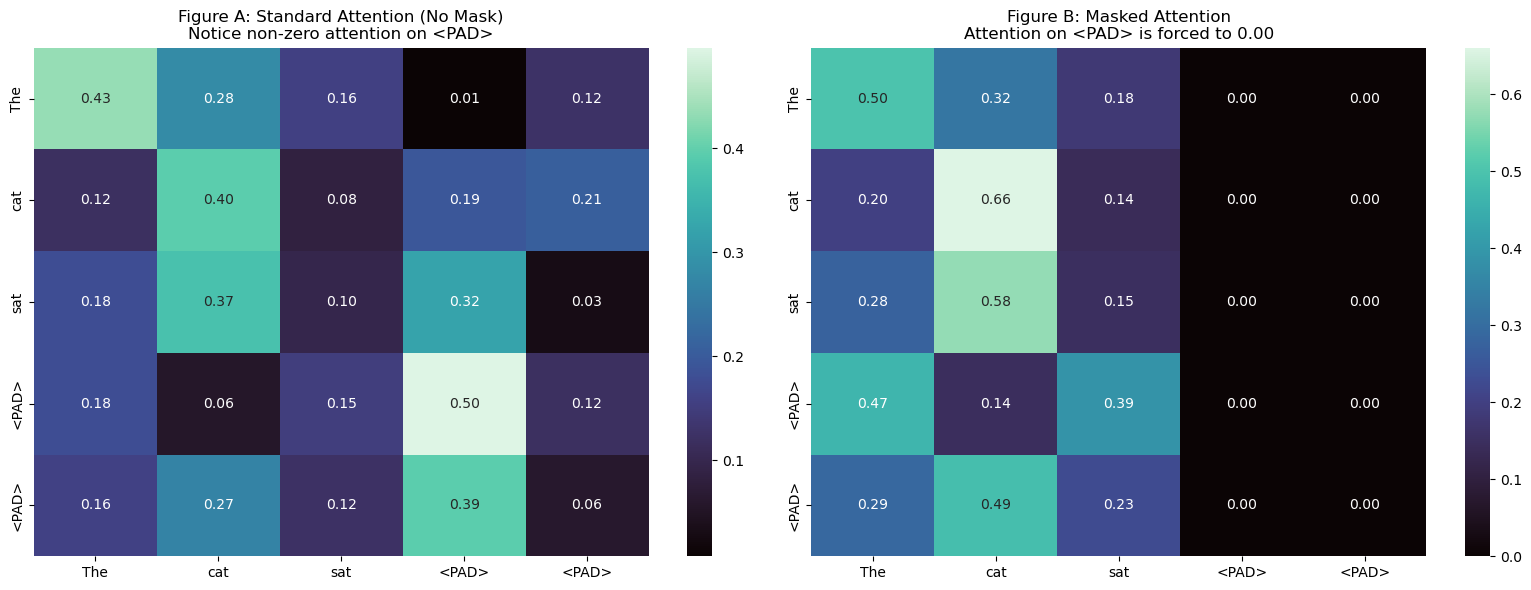

In [9]:
# Padded tokens: "<PAD>", "<PAD>" (to reach max_length of 5)
tokens = ["The", "cat", "sat", "<PAD>", "<PAD>"]
seq_len = len(tokens)

# 2. Create the Padding Mask
# 1 indicates a 'real' token, 0 indicates a 'padding' token
# Mask shape: (1, 1, 5) to allow broadcasting across Query and Key dimensions
mask = torch.tensor([[[1, 1, 1, 0, 0]]]) 

# 3. Simulate Attention Scores (Pre-softmax)
torch.manual_seed(42)
raw_scores = torch.randn(1, seq_len, seq_len)

# --- Experiment A: Without Masking ---
# The model treats <PAD> tokens as valid semantic information,not 0.00
weights_no_mask = F.softmax(raw_scores, dim=-1)

# --- Experiment B: With Padding Mask ---
# This ensures that e^(-1e9) becomes 0 during the Softmax operation
masked_scores = raw_scores.masked_fill(mask == 0, -1e9)
weights_with_mask = F.softmax(masked_scores, dim=-1)

# 4. Visualization for Portfolio Presentation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: No Masking
sns.heatmap(weights_no_mask[0].detach().numpy(), annot=True, fmt=".2f", cmap='mako',
            xticklabels=tokens, yticklabels=tokens, ax=ax1)
ax1.set_title("Figure A: Standard Attention (No Mask)\nNotice non-zero attention on <PAD>")

# Plot B: With Padding Mask
sns.heatmap(weights_with_mask[0].detach().numpy(), annot=True, fmt=".2f", cmap='mako',
            xticklabels=tokens, yticklabels=tokens, ax=ax2)
ax2.set_title("Figure B: Masked Attention\nAttention on <PAD> is forced to 0.00")

plt.tight_layout()
plt.savefig("../output/padding_mask_effect_comparison.png")
plt.show()

### Critical Analysis: Padding Masks

In practical NLP pipelines, sentences in a batch often have different lengths. To enable parallel processing, shorter sentences are "padded" to match the **longest one**. However, these padding tokens`<PAD>` do not contain semantic value.

**Observations:**
* **Without Masking (Fig A):** The model incorrectly distributes "attention energy" to the `<PAD>` tokens. This means the representation of the word **"cat"** is being influenced by empty placeholders, leading to sub-optimal embeddings.
* **With Masking (Fig B):** By applying a `-1e9` constant to the padding positions before the Softmax, we mathematically ensure their probability becomes zero ($e^{-1e9} \approx 0$). 

**Conclusion:**
It allows the Transformer to process batches of varying lengths simultaneously while ensuring the self-attention mechanism strictly focuses on **relevant linguistic context**, effectively "blinding" the model to the **synthetic noise** of padding.

---

## Experiment 5: Multi-Head Attention vs. Computational Efficiency

In [10]:
d_model = 512
num_heads = 8
d_k = d_model // num_heads # Each head gets a subspace of 64 dimensions

# A sequence of 10 words
batch_size = 1
seq_len = 10
x = torch.randn(batch_size, seq_len, d_model)

print(f"Original Shape: {x.shape} (1 Batch, 10 Words, 512 Features)")

# Reshaping to (Batch, Heads, Seq_Len, d_k)
# This allows the model to process 8 "views" in parallel
x_multi_head = x.view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)

print(f"Multi-Head Shape: {x_multi_head.shape} (1 Batch, 8 Heads, 10 Words, 64 Features)")
print(f"\nResult: The model now has {num_heads} independent 'detectives', each focusing on a {d_k}-dimensional subspace.")

Original Shape: torch.Size([1, 10, 512]) (1 Batch, 10 Words, 512 Features)
Multi-Head Shape: torch.Size([1, 8, 10, 64]) (1 Batch, 8 Heads, 10 Words, 64 Features)

Result: The model now has 8 independent 'detectives', each focusing on a 64-dimensional subspace.


### Critical Analysis: Multi-Head Attention vs. Computational Efficiency

**Logistics 1. What happens with different  values? With multiple heads?**

* **Different  values (Dimension Size):**
    * **Small :** The dot products are small. The attention weights are often too uniform(flat). The model cannot distinguish well between important and unimportant words.
    * **Large :** The dot products become huge. The Softmax function makes the weights "peaky" (one value is near 1.0, others are near 0.0). This causes **vanishing gradients**, meaning the model stops learning.
    * *Solution:* This is why we divide by  (scaling). It keeps the numbers in a good range for training.


* **Multiple Heads:**
    * **Single Head:** The model only has one "view" of the sentence. It might focus only on syntax (grammar) OR semantics (meaning), but not both.
    * **Multiple Heads:** The model splits the embedding into several smaller parts. Each head learns to focus on **different features**.
    * *Example:* Head 1 focuses on "who did it" (Subject-Verb). Head 2 focuses on "when it happened" (Time). The model captures complex relationships better using heatmap overlap.


**Logistics 2. Self-attention: What patterns emerge?**
* **The Diagonal Pattern:** The strongest attention is usually on the **diagonal line** of the heatmap. This means every word pays the most attention to **itself**.
* **Semantic Linking:** Words pay attention to other related words, even if they are far away.
* *Example:* In "The **bank** near the river gave me **money**," the word "bank" will have high attention weights for "river" and "money" to understand context.
* **Repetition:** If a word appears twice, they will strongly attend to each other.

**Analysis 1. The Power of Diversity**
It splits the $d_{model}$ into $h$ subspaces. 
* **The Single-Head Limitation:** A single head is forced to average all relationships. It might focus on the **syntax** but miss the **nuance** (e.g., "sarcasm" or "temporal context").
* **The Multi-Head Advantage:** With 8 or 16 heads, the model can multi-task. 
    * *Head 1* might track **Grammar** (Who did what?).
    * *Head 2* might track **Time** (When did it happen?).
    * *Head 3* might track **Entity relationships** .
The final output is a concatenation of these diverse "perspectives," creating a far more robust representation than any single head could achieve.

**Analysis 2. The Heavy Price: $O(n^2)$ Complexity**
However, this intelligence comes with a significant cost. The core of the attention mechanism is the $QK^T$ matrix multiplication, which has a **spatial and temporal complexity of $O(n^2)$**, where $n$ is the sequence length.

* **The Scaling Issue:** As the number of heads and sequence length increase, the memory requirement grows quadratically. For a sequence of 512 tokens, the attention matrix is $512 \times 512$. But for a long document of 16,000 tokens, the matrix explodes to $256,000,000$ elements per head!

* **Trade-off: Is it always worth it?**
    * **For Short Text (Chatbots):** More heads are almost always better as they capture richer context.
    * **For Long-Form Analysis (Books/Legal Docs):** The $O(n^2)$ bottleneck makes standard Multi-Head Attention nearly impossible to run on consumer hardware. 